all

shape of s: (10000, 2)


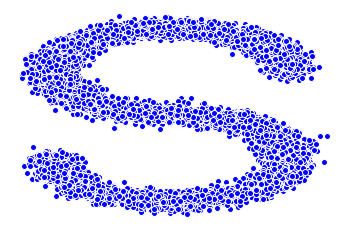

all the same shape torch.Size([100])
Training model...
tensor(0.5687, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

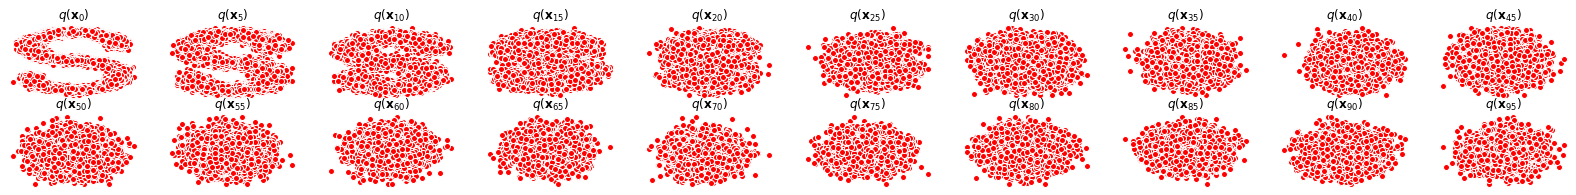

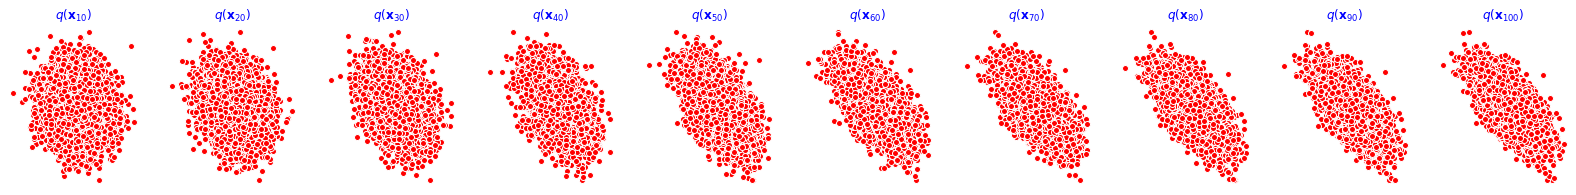

In [7]:
#diffusion_model_test_1.py
#目標
#1.先利用s_curve先生成一個三維s
#2.轉換成二維並畫出平面的s
#3.轉換成二維張量

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
from mpl_toolkits.mplot3d import Axes3D 
import torch

s_curve,_ = make_s_curve(10**4,noise=0.1) # 生成10000個點的S曲線，噪聲強度0.1
s_curve = s_curve[:,[0,2]]/10.0 #只取第1跟第3維度，並除以10(/10)調整比例方便閱讀

print("shape of s:",np.shape(s_curve)) #印出數據s_curve的形狀 (只有二維，10000個點) (10000,2)

data = s_curve.T #.T 是Numpy的轉置操作將行變成列，列變成行。
#EX:原本 s_curve 是一個 (10000, 3) 的矩陣，轉置後變成 (3, 10000)，用意是每一列代表 X、Y 和 Z 軸的坐標，方便在後續的繪圖操作中使用。
#(2,10000)

fig,ax = plt.subplots() #plt.subplots()是matplotlib的函數 設定抓出整個圖形(fig)跟子圖形(ax)來設定

ax.scatter(*data,color='blue',edgecolor='white'); #*data是一種是將參數分離的語法，轉置過的data設定數據點顏色藍色，邊緣白的
#scatter可以繪製散點圖

ax.axis('off')#隱藏坐標軸

dataset = torch.Tensor(s_curve).float()#把s_curve變成張量，資料型別float 二維張量 用於後續操作
'''
標量（0維張量）：
僅有一個數值，例如 5 或 3.14。這是最基本的張量。

向量（1維張量）：
由一組數值組成的列表，例如 [1, 2, 3]。這可以表示一個一維的數據集合。

矩陣（2維張量）：
由多個向量組成的表格（數據結構），例如：
[[1, 2, 3],
 [4, 5, 6]]
這表示一個包含兩行三列的數據結構。

高維張量（3維及以上）：
當數據的維度大於 2 時，可以使用張量來表示，例如：
3維張量可以想像成一個立方體（例如，圖片的 RGB 數據）。
4維張量可以用來表示一批圖片（例如，批量的圖片數據）。
'''
plt.show() 

#顯示圖形

#diffusion_model_test_2.py
#目標
#1.設置參數及初始化

num_steps = 100 #設置步數100

#設定β的值
#β 是每一步添加的噪聲強度
betas = torch.linspace(-6,6,num_steps) #我也不知道為啥是-6~6，就隨機向量分布而已ㄅ，然後有100步
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5 #把Betas sigmoid(0~1)，然後*(0.5e-2 - 1e-5)+1e-5 
#(0.5e-2 - 1e-5)約為0.04，用意是把sigmoid的輸出控制再這個範圍(0~0.04)，然後加一個常數避免有0

#設定α的值 
#α 值代表的是在每一步中保留原始數據的部分，而 β 是添加的噪聲強度。因此，α 可以視為數據中保留的成分
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0) #torch.cumprod 函數計算沿著指定維度的累積乘積。這意味著每個步驟的 α 值將與之前所有步驟的 α 值相乘，以得到到目前為止的總保留成分。
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0) #再alphas_prod張量最前面放置一個1
'''
ex
Alphas: tensor([0.9999, 0.9998, 0.9995, 0.9991, 0.9985, 0.9985, 0.9991, 0.9995, 0.9998, 0.9999])
Alphas Product: tensor([0.9999, 0.9997(0.9999*0.9998), 0.9992, 0.9983, 0.9968, 0.9968, 0.9976, 0.9985, 0.9993, 0.9999])
Alphas Product P: tensor([1.0000, 0.9999, 0.9997, 0.9992, 0.9983, 0.9968, 0.9968, 0.9976, 0.9985, 0.9993])
'''

alphas_bar_sqrt = torch.sqrt(alphas_prod) #算alphas_prod的平方根
one_minus_alphas_bar_log = torch.log(1 - alphas_prod) #torch的log默認是loge
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
#擴散程度的指標?

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape 
#assert 語句：這是一個用於檢查條件的語句。
#如果條件為 False，則會引發 AssertionError，並停止程式的執行。這樣的語句常用於檢查代碼中的假設或邊界條件。
'''
這行代碼確認以下幾個張量的形狀是否一致：
alphas
alphas_prod
alphas_prod_p
alphas_bar_sqrt
one_minus_alphas_bar_log
one_minus_alphas_bar_sqrt
'''
print("all the same shape",betas.shape)
#ex: all the same shape torch.Size([100])

#diffusion_model_test_3.py
#目標
#1.Forward process的邏輯

def q_x(x_0,t):
    """可以用x[0]得到任意t的x[t]"""
    # 計算給定時間t的樣本x[t]

    #表示從原始數據 𝑥0 根據時間步𝑡 生成新的樣本 𝑥[𝑡]的過程。
    # x_0：dataset，原始(10000, 2)的數據
    # t: torch.tensor([i]),i為採樣了幾次

    noise = torch.randn_like(x_0) #生成與原始數據形狀相同的隨機躁聲 就是ppt的 ε~N(0,1)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)
    # x[t] = √αt⋅x0 + √1−αt ⋅ ε(noise)
    # 跟李教授的影片一樣

#diffusion_model_test_4.py
#目標
#1.添加躁聲且過程可視化

num_shows = 20 #顯示20個過程
fig,axs = plt.subplots(2,10,figsize=(28,3)) #前面那個畫圖的fig跟axs (x,y,z) 2行,10列.size
plt.rc('text',color='black') #文字黑

#共有10000個點，每個點包含兩個座標
#生成100步，每隔5步一個圖像
for i in range(num_shows):
    j = i//10 #第x張圖像的對應行數 ex loop到16張 j=1
    k = i%10 #列數 k=6
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) #調用diffusion_model_test_3.py的q_x函數  #生成t時的樣本

    #dataset(10000,2),torch.tensor()=第x步的張量,[i*num_steps//num_shows]=計算我要顯示的步數 ex=第5張 i=5*100//20 ==>會是第25步

    #畫圖瞜
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

#diffusion_model_test_5.py
#目標
#1. Reverse process 啟動

import torch
import torch.nn as nn

#一個MLP 應該是用於denoise
class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128): #初始化
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units), #2維到128維的全連接
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2), #128維回到2維
            ]
        )
        self.step_embeddings = nn.ModuleList( #embedding 三個嵌入層 #nn.modulelist一種 PyTorch 容器 
            [
                nn.Embedding(n_steps,num_units), #nn.embedding(100,128) 將100個時間步丟入128維中 #https://ithelp.ithome.com.tw/articles/10222044
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]#使得模型能夠根據時間步的不同獲得可學習的嵌入特徵，這樣有助於增強模型在擴散過程中的表現。
        )
    def forward(self,x,t): #forward propagation
        #  x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings): 
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x
    

# nn.Embedding：https://blog.csdn.net/qq_39540454/article/details/115215056
# 使用範例
# model = MLPDiffusion(num_steps)
# output = model(x,step)
#diffusion_model_test_6.py
#目標
#denoise訓練時的誤差函數?

def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    

    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)

    a = alphas_bar_sqrt[t] # torch.Size([batchsize, 1])
    

    aml = one_minus_alphas_bar_sqrt[t] # torch.Size([batchsize, 1])

    e = torch.randn_like(x_0) # torch.Size([batchsize, 2])
    

    x = x_0*a+e*aml # torch.Size([batchsize, 2])
    

    output = model(x,t.squeeze(-1)) #t.squeeze(-1)為torch.Size([batchsize])
    # output:torch.Size([batchsize, 2])

    return (e - output).square().mean()

#diffusion_model_test_6.py
#目標
#通過反向擴散過程從隨機噪聲生成樣本的過程。
#這兩段代碼實現了擴散模型的反向抽樣過程。p_sample_loop 函數通過多次調用 p_sample 函數

def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

seed = 1234

class EMA(): 
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

# 儲存模型
torch.save(model.state_dict(), 'diffusion_model.pth')



-------------------------------------
#製作4000次epoch，每次100步的過程

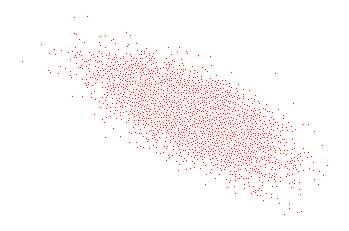

In [9]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset,torch.tensor([i]))
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off');
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

imgs = imgs +reverse
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)